# 第十一組機器學習期末報告


#### 主題 : 機器學習用於股票策略分析

#### Student ID: M132040012 、M134111058

#### Name: 賴冠霖、吳弘曆



# 前置

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2024-12-12 07:57:07--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.204.139, 74.125.204.138, 74.125.204.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.204.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-12-12 07:57:08--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.8.132, 2404:6800:4008:c15::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.8.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  92.3MB/s    in 0.2s    

2024-12-12 07:57:11

# raw data

In [ ]:
data_2454 = pd.read_csv('2454month.csv', encoding='UTF-16', sep='\t')
data_2317 = pd.read_csv('2317month.csv', encoding='UTF-16', sep='\t')

In [ ]:
data_2330 = pd.read_csv('2330monthnew.csv', encoding='UTF-16', sep='\t')
data_2330.info() #查看詳細資訊

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   證券代碼        364 non-null    object 
 1   年月          364 non-null    int64  
 2   開盤價(元)_月    364 non-null    float64
 3   最高價(元)_月    364 non-null    float64
 4   最低價(元)_月    364 non-null    float64
 5   收盤價(元)_月    364 non-null    float64
 6   成交量(百萬股)_月  364 non-null    int64  
 7   成交值(百萬元)_月  364 non-null    int64  
 8   報酬率％_月      364 non-null    float64
 9   週轉率％_月      364 non-null    float64
 10  流通在外股數(千股)  364 non-null    int64  
 11  市值(百萬元)     364 non-null    int64  
 12  最後揭示買價      358 non-null    float64
 13  最後揭示賣價      346 non-null    float64
 14  報酬率-Ln_月    364 non-null    float64
 15  市值比重％       362 non-null    float64
 16  成交值比重％      362 non-null    float64
 17  成交筆數(千筆)    364 non-null    int64  
 18  本益比-TSE     364 non-null    float64
 19  本益比-TEJ     364 non-null    f

In [ ]:
data_2330 #查看資料

,證券代碼,年月,開盤價(元)_月,最高價(元)_月,最低價(元)_月,收盤價(元)_月,成交量(百萬股)_月,成交值(百萬元)_月,報酬率％_月,週轉率％_月,...,本益比-TEJ,股價淨值比-TSE,股價淨值比-TEJ,股價營收比-TEJ,股利殖利率-TSE,現金股利率,股價漲跌(元),高低價差%,市場別,該月結束日
0,2330 台積電,199409,1.66,3.05,1.66,2.95,104,17417,90.0000,13.3299,...,24.89,NaN,10.50,9.41,NaN,NaN,NaN,NaN,TSE,19940930
1,2330 台積電,199410,2.95,3.05,2.66,2.80,92,15422,-5.2632,11.8506,...,19.24,NaN,8.99,7.84,NaN,NaN,-9.0,13.4503,TSE,19941029
2,2330 台積電,199411,2.81,2.81,2.69,2.74,25,3946,-1.8518,3.1646,...,18.89,NaN,8.82,7.69,NaN,NaN,-3.0,4.3210,TSE,19941130
3,2330 台積電,199412,2.74,2.90,2.66,2.71,40,6291,-1.2577,5.0815,...,16.00,NaN,7.47,6.85,NaN,NaN,-2.0,8.8050,TSE,19941231
4,2330 台積電,199501,2.71,2.73,2.35,2.43,33,4738,-10.1912,4.2049,...,14.37,NaN,6.71,6.15,NaN,NaN,-16.0,14.0127,TSE,19950126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,2330 台積電,202408,961.00,968.93,806.28,936.20,1086,996821,1.0709,4.1879,...,28.62,6.46,6.73,10.90,1.38,1.54,10.0,17.5589,TSE,20240830
360,2330 台積電,202409,942.15,1021.08,880.66,953.34,745,705634,1.8084,2.8712,...,29.01,6.55,6.83,11.05,1.36,1.52,13.0,14.5127,TSE,20240930
361,2330 台積電,202410,963.30,1095.79,963.30,1026.06,865,904331,7.6280,3.3362,...,28.87,7.04,7.05,10.95,1.26,1.41,73.0,13.8976,TSE,20241030
362,2330 台積電,202411,992.19,1085.83,988.20,992.19,869,900599,-3.3009,3.3508,...,27.92,6.47,6.81,10.59,1.31,1.58,-34.0,9.5146,TSE,20241129


In [ ]:
data = data_2330.copy()
# data = data_2317.copy()
# data = data_2454.copy()
#若要換成其他的股票在這邊替換

# 數據前處理、視覺化

## 缺失率

In [ ]:
na=data.isna().sum()/data.shape[0] # 計算每個欄位的缺失值比例

data_na={'missing_rate':na} # 將缺失比例存入字典以便轉換為 DataFrame
data_na_df = pd.DataFrame(data_na) # 將字典轉換為 DataFrame，方便進一步處理
data_na_df = data_na_df[data_na_df['missing_rate']>0] # 過濾出缺失率大於 0 的欄位，只顯示有缺失值的欄位
total_missing_rate = sum(data.isna().sum())/(data.shape[0]*data.shape[1]) # 計算資料集總缺失率 (所有欄位的缺失值總和 / 資料總元素數量)

new_row_df = pd.DataFrame({'missing_rate': [total_missing_rate]}, index=['總缺失率']) # 建立新 DataFrame，存放總缺失率的資訊，並命名索引為 '總缺失率'

data_na_df = pd.concat([data_na_df, new_row_df])# 合併個別欄位的缺失率與總缺失率，形成最終的 DataFrame

data_na_df

,missing_rate
最後揭示買價,0.016484
最後揭示賣價,0.049451
市值比重％,0.005495
成交值比重％,0.005495
股價淨值比-TSE,0.362637
股利殖利率-TSE,0.362637
現金股利率,0.021978
股價漲跌(元),0.002747
高低價差%,0.002747
總缺失率,0.025142


## 相關係數矩陣-原始當月特徵

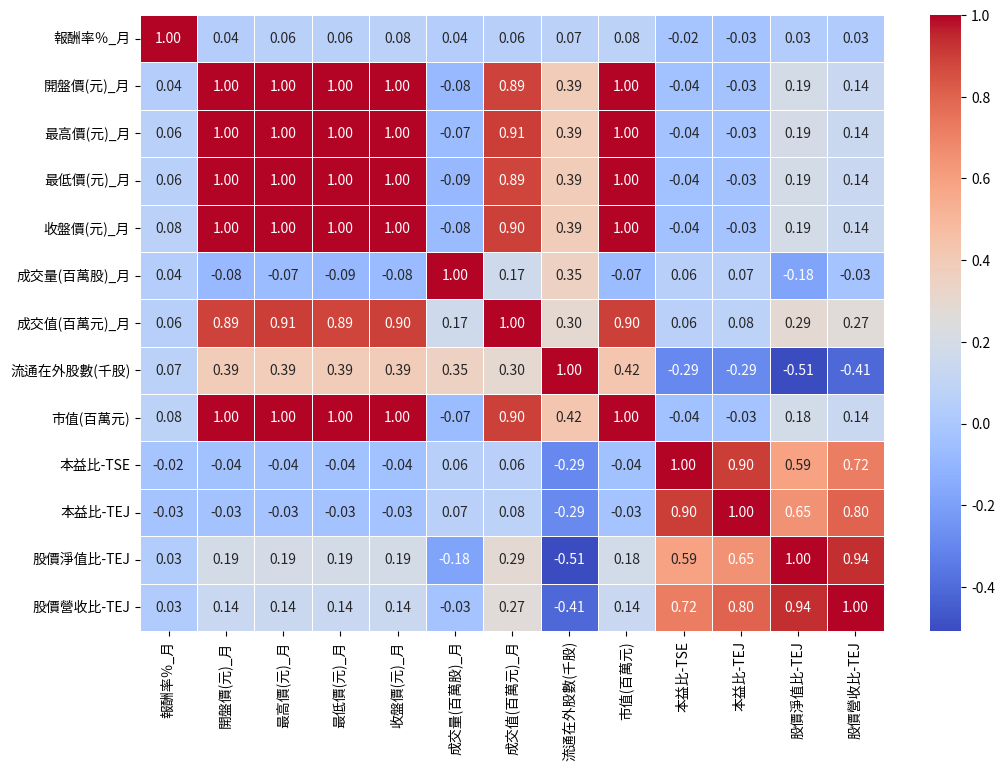

In [ ]:
# 將 '報酬率％_月' 轉換為二元分類：
# 若 '報酬率％_月' 的值大於 0，設為 1；否則設為 0
data['報酬率％_月'] = data['報酬率％_月'].apply(lambda x: 1 if x > 0 else 0)

# 定義特徵欄位
features = [ '報酬率％_月',
        '開盤價(元)_月',
        '最高價(元)_月',
        '最低價(元)_月',
        '收盤價(元)_月',
        '成交量(百萬股)_月',
        '成交值(百萬元)_月',
        '流通在外股數(千股)',
        '市值(百萬元)',
        '本益比-TSE',
        '本益比-TEJ',
        '股價淨值比-TEJ',
        '股價營收比-TEJ'
        ]
data_set0= data[features]

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 設定 Matplotlib 字體以支持中文顯示，避免文字無法正常顯示
plt.rcParams['axes.unicode_minus'] = False
# 計算相關係數矩陣
correlation_matrix = data_set0.corr()

# 可視化相關係數矩陣
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

In [ ]:
# 添加常數項到資料中（通常是用於迴歸模型的截距項）
# 這是計算 VIF 時的必要步驟，因為需要考慮模型中的常數項
data_set0 = add_constant(data_set0)

# 計算 VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = data_set0.columns
# 計算每個特徵的 VIF 值
# variance_inflation_factor 函數參數：
# - data_set0.values: 將資料轉換為數值矩陣形式
# - i: 指定需要計算 VIF 的特徵索引
vif_data['VIF'] = [variance_inflation_factor(data_set0.values, i) for i in range(data_set0.shape[1])]

pd.DataFrame(vif_data)

,Feature,VIF
0,const,39.379920
1,報酬率％_月,1.234846
2,開盤價(元)_月,396.382582
3,最高價(元)_月,1129.257249
4,最低價(元)_月,718.466536
5,收盤價(元)_月,2174.406139
6,成交量(百萬股)_月,2.816388
7,成交值(百萬元)_月,18.989057
8,流通在外股數(千股),9.600862
9,市值(百萬元),1561.749158


## 合併變數

>**當月價格波動**：最高價 - 最低價，反映當月價格波動幅度
>
>**盤價走勢**：收盤價 - 開盤價，反映價格走勢方向
>
>開盤價、最高價、最低價、收盤價 使用"**當月價格波動**"、"**盤價走勢**"取代


>**成交價量比** : 成交值 、 成交量，反映平均交易價格。
>
>成交值 / 成交量 使用"**成交價量比**"取代

>保留「**流通在外股數**」(市值、流通在外股數)
>市值=流通在外股數×股價
>
>只分析單支股票，保留「流通在外股數」 可能更合適，因為流通在外股數在單支股票的情況下一般較為穩定，且市值與股價的波動直接相關。對於單一股票，保留流通在外股數可以提供一些額外的股本資訊，而不需要重複包含股價波動的特徵

>保留「**本益比-TEJ**」(本益比-TSE 、 本益比-TEJ)
>
>原因分析：
>1.  本益比-TSE：
>是根據台灣證券交易所提供的數據計算，可能偏向一般的市場報告格式。
雖然具代表性，但對於一些特定行業或公司而言，未必反映最真實的盈餘水平。
>2.  本益比-TEJ：
>通常考量了本地會計準則，數據涵蓋較完整，適合分析台灣本地的上市公司。
TEJ 數據在台灣投資圈中被廣泛使用，並且往往更細緻，適合進行深入的投資分析。

>保留「**股價淨值比**」( 股價淨值比-TEJ 、 股價營收比-TEJ )
>
>原因分析：
>1.  股價淨值比（Price-to-Book Ratio，P/B Ratio）：
>反映公司股價相對於帳面價值的倍數，適合衡量公司是否被高估或低估。
常用於投資分析中，特別是針對資產密集型產業，因其能反映資產價值的穩定性。
>2.  股價營收比（Price-to-Sales Ratio，P/S Ratio）：
>反映股價相對於營收的倍數，適合評估成長型企業的收入潛力。
雖然能提供公司銷售額的比較，但在單支股票的情境下，營收數字的波動性較大，可能不如股價淨值比穩定。
>
>
>
>

In [ ]:
data['正負報酬'] = data['報酬率％_月'].apply(lambda x: 1 if x > 0 else 0)

data['當月價格波動'] = data['最高價(元)_月'] - data['最低價(元)_月']

data['盤價走勢'] = data['收盤價(元)_月'] - data['開盤價(元)_月']

data['成交價量比'] = data['成交值(百萬元)_月'] / data['成交量(百萬股)_月']


features = [ '正負報酬',
        '當月價格波動',
        '盤價走勢',
        '成交價量比',
        '流通在外股數(千股)',
        '本益比-TEJ',
        '股價淨值比-TEJ']
data_set= data[features]

# data_set = data_set.rename(columns={
#     '正負報酬' : 'return',
#     '當月價格波動' : 'price_volatility',
#     '盤價走勢'  : 'price_trend',
#     '成交價量比' : 'pvr',#price-volume_ratio
#     '流通在外股數(千股)' : 'os',#Outstanding Shares
#     '本益比-TEJ' : 'pe_tej',#P/E Ratio - TEJ
#     '股價淨值比-TEJ' : 'pb_tej'#P/B Ratio - TEJ
#   }
# )


# 準備好的Dataset

In [ ]:
data_set

,正負報酬,當月價格波動,盤價走勢,成交價量比,流通在外股數(千股),本益比-TEJ,股價淨值比-TEJ
0,1,1.39,1.29,167.471154,780000,24.89,10.50
1,0,0.39,-0.15,167.630435,780000,19.24,8.99
2,0,0.12,-0.07,157.840000,780000,18.89,8.82
3,0,0.24,-0.03,157.275000,780000,16.00,7.47
4,0,0.38,-0.28,143.575758,780000,14.37,6.71
...,...,...,...,...,...,...,...
359,1,162.65,-24.80,917.883057,25933629,28.62,6.73
360,1,140.42,11.19,947.159732,25932733,29.01,6.83
361,1,132.49,62.76,1045.469364,25932733,28.87,7.05
362,0,97.63,0.00,1036.362486,25932733,27.92,6.81


## Summary

In [ ]:
summary = data_set.describe()
summary

,正負報酬,當月價格波動,盤價走勢,成交價量比,流通在外股數(千股),本益比-TEJ,股價淨值比-TEJ
count,364.000000,364.000000,364.000000,364.000000,3.640000e+02,364.000000,364.000000
mean,0.590659,15.665604,2.549560,186.227196,2.043003e+07,23.096538,4.915385
std,0.492389,27.537333,17.060122,200.167776,8.675710e+06,15.767154,2.393850
min,0.000000,0.120000,-67.620000,41.807460,7.800000e+05,6.960000,2.230000
25%,0.000000,2.780000,-0.930000,62.770503,1.683255e+07,14.522500,3.400000
50%,1.000000,4.680000,0.430000,103.360362,2.590609e+07,17.210000,3.920000
75%,1.000000,11.585000,2.802500,207.742188,2.593038e+07,26.247500,5.410000
max,1.000000,163.640000,129.160000,1062.446429,2.642766e+07,99.290000,14.910000


## 相關係數矩陣

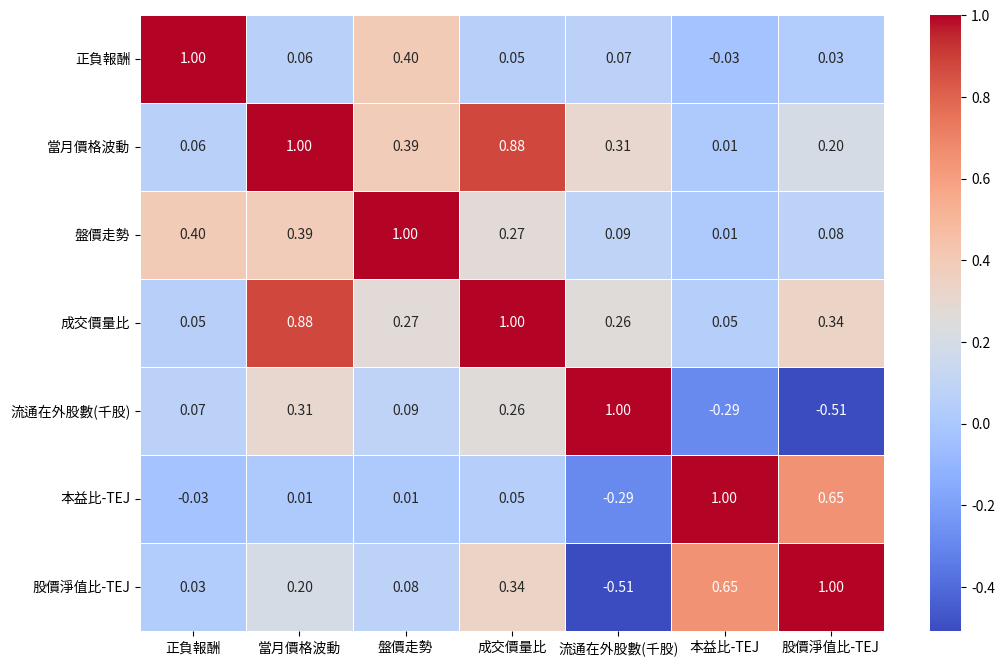

In [ ]:
# 計算相關係數矩陣
correlation_matrix = data_set.corr()

# 可視化相關係數矩陣
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

In [ ]:
data_set = add_constant(data_set)

# 計算 VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = data_set.columns
vif_data['VIF'] = [variance_inflation_factor(data_set.values, i) for i in range(data_set.shape[1])]

pd.DataFrame(vif_data)

,Feature,VIF
0,const,26.765423
1,正負報酬,1.229731
2,當月價格波動,5.265970
3,盤價走勢,1.469128
4,成交價量比,5.793352
5,流通在外股數(千股),2.009328
6,本益比-TEJ,1.965406
7,股價淨值比-TEJ,3.568194


>當月價格波動(price_volatility) 和 成交價量比(pvr) 的相關係數高達 0.87，顯示出兩者之間存在較強的線性關係，但它們仍然提供了不同的市場資訊，並且在目前的 VIF 分析中，各自的 VIF 值（當月價格波動為 4.95 和 成交價量比為 5.56）仍處於可以接受的範圍內

# 建立模型

## 探討五種分類器與滯後期數 (lag=1~5) 的模型準確率

In [ ]:
# 5 個分類器
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(solver='saga', max_iter=3000),
}

In [ ]:
def train_lagged_model_sequential(data, target, classifier, lag_k=1):
    """
    使用指定的滯後期數訓練模型並評估性能，依照順序切割為訓練、驗證與測試集。

    Args:
        data (pd.DataFrame): 包含特徵和目標變數的原始資料。
        target (str): 目標變數名稱。
        classifier (object): 分類器實例，例如 RandomForestClassifier()。
        lag_k (int): 滯後期數。

    Returns:
        dict: 包括準確率及特徵重要性的結果。
    """
    # 複製原始資料
    df = data.copy()

    # 將"正負報酬"往前移一格 (目的是預測下個月的正負報酬)
    df[f"{target}_next"] = df[target].shift(-1)

    # 創建滯後特徵
    for col in df.columns:
        if col != target:  # 跳過目標變數
            for lag in range(1, lag_k + 1):
                df[f"{col}_lag{lag}"] = df[col].shift(lag)

    # 刪除空值 (包括目標變數滯後造成的空值)
    df = df.dropna()

    # 特徵與目標變數
    X = df.drop([target, f"{target}_next"], axis=1)
    y = df[f"{target}_next"]

    # 台積電 : 資料分割 (照順序分割：訓練集 219 筆、驗證集 72 筆、測試集最後 72 筆=363)
    # 鴻 海 : 資料分割 (照順序分割：訓練集 242 筆、驗證集 80 筆、測試集最後 80 筆=402)
    # 聯發科 : 資料分割 (照順序分割：訓練集 219 筆、驗證集 56 筆、測試集最後 56 筆 =281)
    train_size = 219
    valid_size = 72

    X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
    X_valid, y_valid = X.iloc[train_size:train_size + valid_size], y.iloc[train_size:train_size + valid_size]
    X_test, y_test = X.iloc[train_size + valid_size:], y.iloc[train_size + valid_size:]

    # 模型訓練
    classifier.fit(X_train, y_train)

    # 驗證集評估
    y_valid_pred = classifier.predict(X_valid)
    valid_accuracy = accuracy_score(y_valid, y_valid_pred)

    # 測試集評估
    y_test_pred = classifier.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # 特徵重要性
    feature_importance = None
    if hasattr(classifier, "feature_importances_"):
        feature_importance = pd.DataFrame({
            "Feature": X.columns,
            "Importance": classifier.feature_importances_
        }).sort_values(by="Importance", ascending=False)

    # 返回結果
    return {
        "valid_accuracy": valid_accuracy,
        "test_accuracy": test_accuracy,
        "feature_importance": feature_importance
    }


In [ ]:
results_summary = []
results = []

# 遍歷分類器
for name, clf in classifiers.items():
    print(f"\n分類器: {name}")
    max_accuracy = 0
    best_lag_k = 0
    best_feature_importance = None

    # 測試不同的滯後期數 lag_k
    for lag_k in range(1, 6):  # 測試 lag_k = 1 到 5
        result = train_lagged_model_sequential(data_set, target="正負報酬", classifier=clf, lag_k=lag_k)
        valid_accuracy = result['valid_accuracy']
        test_accuracy = result['test_accuracy']
        feature_importance = result['feature_importance']

        print(f"lag_k = {lag_k}, valid準確率: {valid_accuracy:.4f}, test準確率: {test_accuracy:.4f}")

        # 更新最佳結果 (以測試集準確率為準)
        if valid_accuracy > max_accuracy:
            max_accuracy = valid_accuracy
            best_lag_k = lag_k
            best_feature_importance = feature_importance

    # 儲存結果到 results_summary 和 results
    results_summary.append(
        f"分類器 {name.ljust(22)} 在 lag_k = {str(best_lag_k).ljust(2)} 時達到最大驗證準確率: {max_accuracy:.4f}"
    )
    results.append({
        "classifiers": name,
        "lag_k": best_lag_k,
        "valid_accuracy": valid_accuracy,
        "test_accuracy": max_accuracy,
        "feature_importance": best_feature_importance,
    })

# 輸出結果
print('\n結果摘要:')
print("\n".join(results_summary))



分類器: Random Forest
lag_k = 1, valid準確率: 0.4583, test準確率: 0.3944
lag_k = 2, valid準確率: 0.5000, test準確率: 0.4143
lag_k = 3, valid準確率: 0.5833, test準確率: 0.4348
lag_k = 4, valid準確率: 0.5000, test準確率: 0.3971
lag_k = 5, valid準確率: 0.5694, test準確率: 0.5522

分類器: Gradient Boosting
lag_k = 1, valid準確率: 0.4167, test準確率: 0.3803
lag_k = 2, valid準確率: 0.4028, test準確率: 0.4000
lag_k = 3, valid準確率: 0.4028, test準確率: 0.3768
lag_k = 4, valid準確率: 0.4167, test準確率: 0.3824
lag_k = 5, valid準確率: 0.4722, test準確率: 0.4179

分類器: Support Vector Machine
lag_k = 1, valid準確率: 0.6111, test準確率: 0.6338
lag_k = 2, valid準確率: 0.6111, test準確率: 0.6286
lag_k = 3, valid準確率: 0.6250, test準確率: 0.6232
lag_k = 4, valid準確率: 0.6250, test準確率: 0.6176
lag_k = 5, valid準確率: 0.6111, test準確率: 0.6269

分類器: K-Nearest Neighbors
lag_k = 1, valid準確率: 0.6111, test準確率: 0.6338
lag_k = 2, valid準確率: 0.6111, test準確率: 0.6286
lag_k = 3, valid準確率: 0.6250, test準確率: 0.6232
lag_k = 4, valid準確率: 0.6250, test準確率: 0.6176
lag_k = 5, valid準確率: 0.6111, test準確率: 0.6269



> 上面結果可以看出使用SVM、KNN、Logistic Regression進行分類且在lag=1時，在驗證集最大準確率:0.625
>
> 下圖可視畫

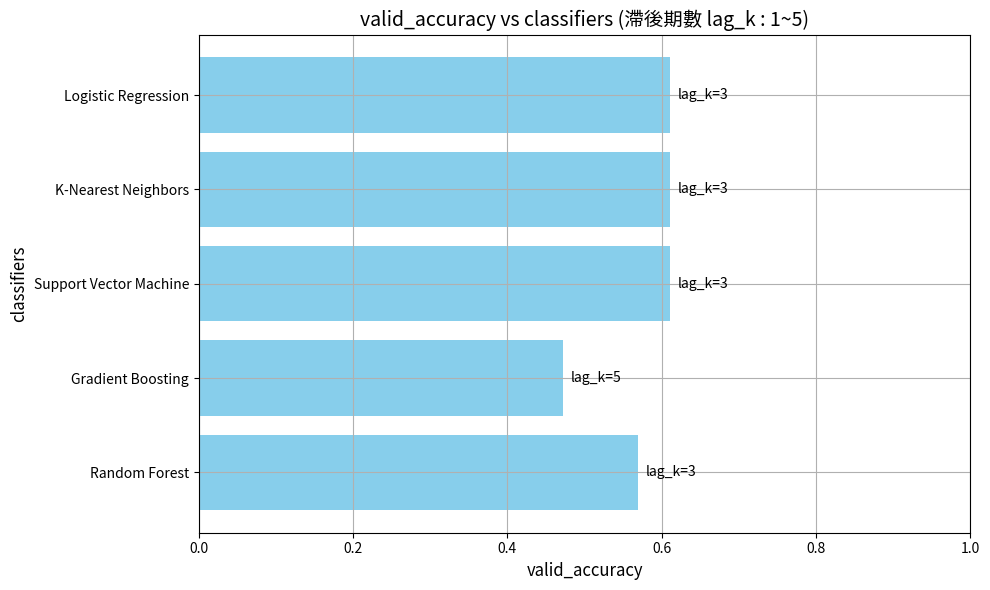

In [ ]:
classifiers = [d["classifiers"] for d in results]
lag_ks = [d["lag_k"] for d in results]
accuracies = [d["valid_accuracy"] for d in results]

# 創建條形圖
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(classifiers, accuracies, color="skyblue")

# 在條形圖上標記 lag_k 值
for bar, lag_k in zip(bars, lag_ks):
    ax.text(
        bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
        f"lag_k={lag_k}", va="center", ha="left", fontsize=10
    )

# 設置圖表標題和標籤
ax.set_title("valid_accuracy vs classifiers (滯後期數 lag_k : 1~5)", fontsize=14)
ax.set_xlabel("valid_accuracy", fontsize=12)
ax.set_ylabel("classifiers", fontsize=12)
ax.set_xlim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

> 由上圖可以看出使用Logistic Regression進行分類且在lag=1時，有最大準確率:0.6849

## 特徵重要性

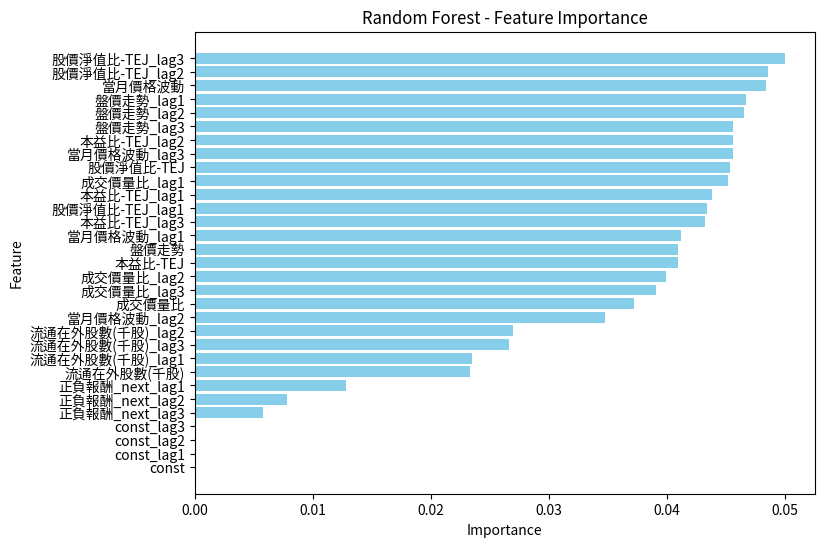

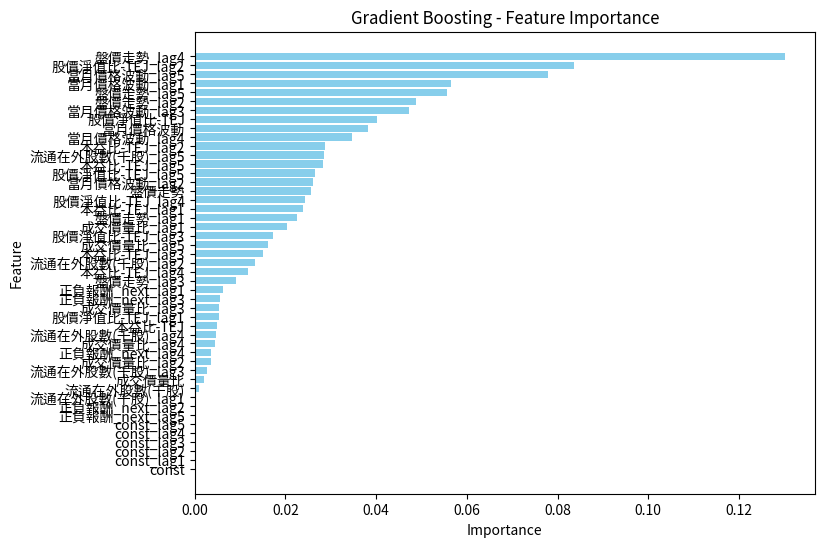

In [ ]:
# 從 results 中篩選支持特徵重要性的分類器
for res in results:
    if res['feature_importance'] is not None:  # 確保有特徵重要性資料
        # 取得分類器名稱和特徵重要性
        classifier_name = res['classifiers']
        feature_importance = res['feature_importance']

        # 繪圖
        plt.figure(figsize=(8, 6))
        plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title(f'{classifier_name} - Feature Importance')
        plt.gca().invert_yaxis()  # 反轉 y 軸，重要性高的特徵放上面
        plt.show()

使用rf進行訓練，在測試集的準確率為0.7895。

# 抓出 5個 best model 中的 y_test_pred

In [ ]:
def train_best_model(data, target, lag_k, classifier, test_size=72, valid_size=72):
    """
    針對最佳模型的參數進行訓練並返回測試集的預測值。

    Args:
        data (pd.DataFrame): 包含特徵和目標變數的原始資料。
        target (str): 目標變數名稱。
        lag_k (int): 最佳滯後期數。
        classifier (object): 最佳分類器，例如 LogisticRegression()。
        test_size (int): 測試集大小。
        valid_size (int): 驗證集大小。

    Returns:
        pd.Series: 測試集的預測標籤值。
    """
    # 複製原始資料
    df = data.copy()

    # 將"正負報酬"往前移一格 (目的: 預測下一期的正負報酬)
    df[f"{target}_next"] = df[target].shift(-1)

    # 創建滯後特徵
    for col in df.columns:
        if col != target:  # 跳過目標變數
            for lag in range(1, lag_k + 1):
                df[f"{col}_lag{lag}"] = df[col].shift(lag)

    # 刪除空值 (包括目標變數滯後造成的空值)
    df = df.dropna()

    # 特徵與目標變數
    X = df.drop([target, f"{target}_next"], axis=1)
    y = df[f"{target}_next"]

    # 按順序切割資料集
    train_size = len(df) - test_size - valid_size
    X_train, X_valid, X_test = X.iloc[:train_size], X.iloc[train_size:train_size + valid_size], X.iloc[train_size + valid_size:]
    y_train, y_valid, y_test = y.iloc[:train_size], y.iloc[train_size:train_size + valid_size], y.iloc[train_size + valid_size:]

    # 模型訓練
    classifier.fit(X_train, y_train)

    # 測試集預測
    label_pred = classifier.predict(X_test)

    # 返回測試集的預測標籤
    return pd.Series(label_pred, index=X_test.index)


## True label in test

In [ ]:
true_label = data_set.iloc[-72:]['正負報酬']
true_label

,正負報酬
292,0
293,1
294,1
295,1
296,0
...,...
359,1
360,1
361,1
362,0


## Pred label in test

### RF

In [ ]:
rf = train_best_model(data_set, target="正負報酬", lag_k=3, classifier =  RandomForestClassifier(random_state=42), test_size=72, valid_size=72)
rf.rename("rf", inplace=True)
rf

,rf
291,1.0
292,1.0
293,0.0
294,0.0
295,0.0
...,...
358,0.0
359,0.0
360,0.0
361,0.0


### Gradient Boosting

In [ ]:
gb = train_best_model(data_set, target="正負報酬", lag_k=5, classifier =  GradientBoostingClassifier(random_state=42), test_size=72, valid_size=72)
gb.rename("gb", inplace=True)
gb

,gb
291,0.0
292,0.0
293,0.0
294,0.0
295,0.0
...,...
358,0.0
359,0.0
360,0.0
361,0.0


### SVM

In [ ]:
svm = train_best_model(data_set, target="正負報酬", lag_k=3, classifier =  SVC(), test_size=72, valid_size=72)
svm.rename("svm", inplace=True)
svm

,svm
291,1.0
292,1.0
293,1.0
294,1.0
295,1.0
...,...
358,1.0
359,1.0
360,1.0
361,1.0


### KNN

In [ ]:
knn = train_best_model(data_set, target="正負報酬", lag_k=3, classifier =  KNeighborsClassifier(), test_size=72, valid_size=72)
knn.rename("knn", inplace=True)
knn

,knn
291,1.0
292,1.0
293,1.0
294,1.0
295,1.0
...,...
358,1.0
359,1.0
360,1.0
361,1.0


### Logistic Regression


In [ ]:
logistic = train_best_model(data_set, target="正負報酬", lag_k=3, classifier = LogisticRegression(solver='saga', max_iter=3000), test_size=72, valid_size=72)
logistic.rename("logistic", inplace=True)
logistic

,logistic
291,1.0
292,1.0
293,1.0
294,1.0
295,1.0
...,...
358,1.0
359,1.0
360,1.0
361,1.0


## 合併資料

In [ ]:
df = data.copy()
features = [ '年月',
        '收盤價(元)_月',
        '開盤價(元)_月',
        '正負報酬']
data_csv= df[features]
# data_csv= data_csv.iloc[291:,:]

data_csv["正負報酬"] = data_csv['正負報酬'].shift(-1)
data_csv = data_csv.dropna()
data_csv= data_csv.iloc[-72:,:]
data_csv

<ipython-input-69-1f4a83a69550>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_csv["正負報酬"] = data_csv['正負報酬'].shift(-1)


,年月,收盤價(元)_月,開盤價(元)_月,正負報酬
291,201812,193.63,198.35,0.0
292,201901,189.76,194.49,1.0
293,201902,205.22,195.77,1.0
294,201903,210.80,205.65,1.0
295,201904,222.39,215.52,0.0
...,...,...,...,...
358,202407,926.28,960.00,1.0
359,202408,936.20,961.00,1.0
360,202409,953.34,942.15,1.0
361,202410,1026.06,963.30,0.0


## 存成CSV檔

In [ ]:
data_rf = pd.concat([data_csv.reset_index(drop=True), rf.reset_index(drop=True)], axis=1)
data_gb = pd.concat([data_csv.reset_index(drop=True), gb.reset_index(drop=True)], axis=1)
data_svm = pd.concat([data_csv.reset_index(drop=True), svm.reset_index(drop=True)], axis=1)
data_knn = pd.concat([data_csv.reset_index(drop=True), knn.reset_index(drop=True)], axis=1)
data_logistic = pd.concat([data_csv.reset_index(drop=True), logistic.reset_index(drop=True)], axis=1)

data_rf.to_csv("data_2330_rf.csv", index=False)
data_gb.to_csv("data_2330_gb.csv", index=False)
data_svm.to_csv("data_2330_svm.csv", index=False)
data_knn.to_csv("data_2330_knn.csv", index=False)
data_logistic.to_csv("data_2330_logistic.csv", index=False)

# 由 pred label 進行回測

test label_pred 的最後一個值(0/1) : 預測 2024/12 正報酬，所以11月時買入

往回推6年，所以從2018/12 開始買

test label_pred 的第一個值(0/1) : 預測 2018/12 正報酬，所以11月時買入

# 數據小結

結果 : 使用SVM、KNN、Logistic Regression進行分類且在lag=1時，在驗證集最大準確率:0.625

在測試集的準確率皆為test準確率: 0.6338

# 各模型回測比較

測試定額定存與各個模型的買入台灣前三大市值股票的績效 


依據test label_pred 的最後一個值(0/1)下去做策略制定

1.投資策略：

每月固定投入 1000 元，若當期預測值為 1，則將累積現金（包含當期定投的 1000 元）全部用於購買股票，買入價格為當期的「開盤價」。

若當期預測值為 0，則不進行購買操作，將 1000 元累積到後續期數，直至某一期預測值為 1 再進行投資。

2.資產計算：

若發生購買，股票數量將根據累積現金與當期開盤價計算。

計算股票的最終價值，假設持有的股票最後價格等同於該期的「開盤價」乘以下一期漲幅。

3.輸出結果：

股票持有的最終價值。

未投資的累積現金。

總資產的報酬率（總資產相對於總累計投入金額的收益率）。

## 2317 鴻海 

### 定期定存(Regular Saving Plan)


In [10]:
import pandas as pd

# 載入資料
file_path = '/Users/wuyoel/Desktop/python專題/3個股票預測值/data_2317_gb.csv'
data = pd.read_csv(file_path)

# 初始化變數
monthly_investment = 1000  # 每月投入金額
total_cash = 0  # 累積未投資的現金
total_shares = 0  # 持有的股票總數

# 逐月模擬定額定存
for i in range(len(data)):
    invest_price = data.loc[i, "開盤價(元)_月"]  # 當月開盤價
    shares_bought = monthly_investment / invest_price  # 計算購買的股票數量
    total_shares += shares_bought  # 增加持有的股票數量

# 計算最終資產價值
final_stock_price = data.loc[len(data) - 1, "收盤價(元)_月"]  # 最後一月的收盤價
final_stock_value = total_shares * final_stock_price  # 持有股票的最終價值
final_total_cash = final_stock_value + total_cash  # 最終總資金（股票價值 + 現金）

# 計算總報酬率
total_investment = monthly_investment * len(data)  # 總投入金額
return_rate_rsp = (final_total_cash - total_investment) / total_investment  # 總報酬率

# 輸出結果
print("持有股票的最終價值:", round(final_stock_value, 2))
print("累積未投資的現金:", round(total_cash, 2))
print("最終總資金:", round(final_total_cash, 2))
print("總報酬率:", f"{return_rate_rsp:.2%}")

持有股票的最終價值: 187055.38
累積未投資的現金: 0
最終總資金: 187055.38
總報酬率: 133.82%


### 實施策略

### gb

In [12]:
# 初始化變數
monthly_investment = 1000  # 每月固定投入金額
total_cash = 0  # 累積未投資的現金
total_shares = 0  # 持有的股票總數

# 根據 GB 策略模擬
for i in range(len(data)):
    if data.loc[i, "gb"] == 1:  # 當 GB 為 1 時，執行購買
        total_investment = total_cash + monthly_investment  # 累積資金
        purchase_price = data.loc[i, "開盤價(元)_月"]  # 當月開盤價
        shares_bought = total_investment / purchase_price  # 計算購買股票數量
        total_shares += shares_bought  # 增加持有的股票數量
        total_cash = 0  # 清空累積現金
    else:
        total_cash += monthly_investment  # 累積現金

# 計算最終資產價值
final_stock_price = data.loc[len(data) - 1, "收盤價(元)_月"]  # 最後一月的收盤價
final_stock_value = total_shares * final_stock_price  # 持有股票的最終價值
final_total_cash = final_stock_value + total_cash  # 最終總資金（股票價值 + 現金）

# 計算總報酬率
total_investment = monthly_investment * len(data)  # 總投入金額
return_rate = (final_total_cash - total_investment) / total_investment  # 總報酬率

# 輸出結果
print("持有股票的最終價值:", round(final_stock_value, 2))
print("累積未投資的現金:", round(total_cash, 2))
print("最終總資金:", round(final_total_cash, 2))
print("總報酬率:", f"{return_rate:.2%}")

持有股票的最終價值: 36565.12
累積未投資的現金: 68000
最終總資金: 104565.12
總報酬率: 30.71%


### knn

In [13]:
# 載入資料
file_path = '/Users/wuyoel/Desktop/python專題/3個股票預測值/data_2317_knn.csv'
data = pd.read_csv(file_path)
# 初始化變數
monthly_investment = 1000  # 每月固定投入金額
total_cash = 0  # 累積未投資的現金
total_shares = 0  # 持有的股票總數

# 根據 knn 策略模擬
for i in range(len(data)):
    if data.loc[i, "knn"] == 1:  # 當 GB 為 1 時，執行購買
        total_investment = total_cash + monthly_investment  # 累積資金
        purchase_price = data.loc[i, "開盤價(元)_月"]  # 當月開盤價
        shares_bought = total_investment / purchase_price  # 計算購買股票數量
        total_shares += shares_bought  # 增加持有的股票數量
        total_cash = 0  # 清空累積現金
    else:
        total_cash += monthly_investment  # 累積現金

# 計算最終資產價值
final_stock_price = data.loc[len(data) - 1, "收盤價(元)_月"]  # 最後一月的收盤價
final_stock_value = total_shares * final_stock_price  # 持有股票的最終價值
final_total_cash = final_stock_value + total_cash  # 最終總資金（股票價值 + 現金）

# 計算總報酬率
total_investment = monthly_investment * len(data)  # 總投入金額
return_rate = (final_total_cash - total_investment) / total_investment  # 總報酬率

# 輸出結果
print("持有股票的最終價值:", round(final_stock_value, 2))
print("累積未投資的現金:", round(total_cash, 2))
print("最終總資金:", round(final_total_cash, 2))
print("總報酬率:", f"{return_rate:.2%}")

持有股票的最終價值: 0.0
累積未投資的現金: 80000
最終總資金: 80000.0
總報酬率: 0.00%


### logistic

In [14]:
# 載入資料
file_path = '/Users/wuyoel/Desktop/python專題/3個股票預測值/data_2317_logistic.csv'
data = pd.read_csv(file_path)
# 初始化變數
monthly_investment = 1000  # 每月固定投入金額
total_cash = 0  # 累積未投資的現金
total_shares = 0  # 持有的股票總數

# 根據 knn 策略模擬
for i in range(len(data)):
    if data.loc[i, "logistic"] == 1:  # 當 GB 為 1 時，執行購買
        total_investment = total_cash + monthly_investment  # 累積資金
        purchase_price = data.loc[i, "開盤價(元)_月"]  # 當月開盤價
        shares_bought = total_investment / purchase_price  # 計算購買股票數量
        total_shares += shares_bought  # 增加持有的股票數量
        total_cash = 0  # 清空累積現金
    else:
        total_cash += monthly_investment  # 累積現金

# 計算最終資產價值
final_stock_price = data.loc[len(data) - 1, "收盤價(元)_月"]  # 最後一月的收盤價
final_stock_value = total_shares * final_stock_price  # 持有股票的最終價值
final_total_cash = final_stock_value + total_cash  # 最終總資金（股票價值 + 現金）

# 計算總報酬率
total_investment = monthly_investment * len(data)  # 總投入金額
return_rate = (final_total_cash - total_investment) / total_investment  # 總報酬率

# 輸出結果
print("持有股票的最終價值:", round(final_stock_value, 2))
print("累積未投資的現金:", round(total_cash, 2))
print("最終總資金:", round(final_total_cash, 2))
print("總報酬率:", f"{return_rate:.2%}")

持有股票的最終價值: 25664.59
累積未投資的現金: 72000
最終總資金: 97664.59
總報酬率: 22.08%


### rf

In [15]:
# 載入資料
file_path = '/Users/wuyoel/Desktop/python專題/3個股票預測值/data_2317_rf.csv'
data = pd.read_csv(file_path)
# 初始化變數
monthly_investment = 1000  # 每月固定投入金額
total_cash = 0  # 累積未投資的現金
total_shares = 0  # 持有的股票總數

# 根據 knn 策略模擬
for i in range(len(data)):
    if data.loc[i, "rf"] == 1:  # 當 GB 為 1 時，執行購買
        total_investment = total_cash + monthly_investment  # 累積資金
        purchase_price = data.loc[i, "開盤價(元)_月"]  # 當月開盤價
        shares_bought = total_investment / purchase_price  # 計算購買股票數量
        total_shares += shares_bought  # 增加持有的股票數量
        total_cash = 0  # 清空累積現金
    else:
        total_cash += monthly_investment  # 累積現金

# 計算最終資產價值
final_stock_price = data.loc[len(data) - 1, "收盤價(元)_月"]  # 最後一月的收盤價
final_stock_value = total_shares * final_stock_price  # 持有股票的最終價值
final_total_cash = final_stock_value + total_cash  # 最終總資金（股票價值 + 現金）

# 計算總報酬率
total_investment = monthly_investment * len(data)  # 總投入金額
return_rate = (final_total_cash - total_investment) / total_investment  # 總報酬率

# 輸出結果
print("持有股票的最終價值:", round(final_stock_value, 2))
print("累積未投資的現金:", round(total_cash, 2))
print("最終總資金:", round(final_total_cash, 2))
print("總報酬率:", f"{return_rate:.2%}")

持有股票的最終價值: 180922.79
累積未投資的現金: 4000
最終總資金: 184922.79
總報酬率: 131.15%


### SVM

In [16]:
# 載入資料
file_path = '/Users/wuyoel/Desktop/python專題/3個股票預測值/data_2317_svm.csv'
data = pd.read_csv(file_path)
# 初始化變數
monthly_investment = 1000  # 每月固定投入金額
total_cash = 0  # 累積未投資的現金
total_shares = 0  # 持有的股票總數

# 根據 knn 策略模擬
for i in range(len(data)):
    if data.loc[i, "svm"] == 1:  # 當 GB 為 1 時，執行購買
        total_investment = total_cash + monthly_investment  # 累積資金
        purchase_price = data.loc[i, "開盤價(元)_月"]  # 當月開盤價
        shares_bought = total_investment / purchase_price  # 計算購買股票數量
        total_shares += shares_bought  # 增加持有的股票數量
        total_cash = 0  # 清空累積現金
    else:
        total_cash += monthly_investment  # 累積現金

# 計算最終資產價值
final_stock_price = data.loc[len(data) - 1, "收盤價(元)_月"]  # 最後一月的收盤價
final_stock_value = total_shares * final_stock_price  # 持有股票的最終價值
final_total_cash = final_stock_value + total_cash  # 最終總資金（股票價值 + 現金）

# 計算總報酬率
total_investment = monthly_investment * len(data)  # 總投入金額
return_rate = (final_total_cash - total_investment) / total_investment  # 總報酬率

# 輸出結果
print("持有股票的最終價值:", round(final_stock_value, 2))
print("累積未投資的現金:", round(total_cash, 2))
print("最終總資金:", round(final_total_cash, 2))
print("總報酬率:", f"{return_rate:.2%}")

持有股票的最終價值: 0.0
累積未投資的現金: 80000
最終總資金: 80000.0
總報酬率: 0.00%


# 2454 聯發科

### 定期定存(Regular Saving Plan)


In [17]:
# 載入資料
file_path = '/Users/wuyoel/Desktop/python專題/3個股票預測值/data_2454_gb.csv'
data = pd.read_csv(file_path)

# 初始化變數
monthly_investment = 1000  # 每月投入金額
total_cash = 0  # 累積未投資的現金
total_shares = 0  # 持有的股票總數

# 逐月模擬定額定存
for i in range(len(data)):
    invest_price = data.loc[i, "開盤價(元)_月"]  # 當月開盤價
    shares_bought = monthly_investment / invest_price  # 計算購買的股票數量
    total_shares += shares_bought  # 增加持有的股票數量

# 計算最終資產價值
final_stock_price = data.loc[len(data) - 1, "收盤價(元)_月"]  # 最後一月的收盤價
final_stock_value = total_shares * final_stock_price  # 持有股票的最終價值
final_total_cash = final_stock_value + total_cash  # 最終總資金（股票價值 + 現金）

# 計算總報酬率
total_investment = monthly_investment * len(data)  # 總投入金額
return_rate = (final_total_cash - total_investment) / total_investment  # 總報酬率

# 輸出結果
print("持有股票的最終價值:", round(final_stock_value, 2))
print("累積未投資的現金:", round(total_cash, 2))
print("最終總資金:", round(final_total_cash, 2))
print("總報酬率:", f"{return_rate:.2%}")

持有股票的最終價值: 107785.11
累積未投資的現金: 0
最終總資金: 107785.11
總報酬率: 92.47%


### gb

In [18]:
# 載入資料
file_path = '/Users/wuyoel/Desktop/python專題/3個股票預測值/data_2454_gb.csv'
data = pd.read_csv(file_path)
# 初始化變數
monthly_investment = 1000  # 每月固定投入金額
total_cash = 0  # 累積未投資的現金
total_shares = 0  # 持有的股票總數

# 根據 knn 策略模擬
for i in range(len(data)):
    if data.loc[i, "gb"] == 1:  # 當 GB 為 1 時，執行購買
        total_investment = total_cash + monthly_investment  # 累積資金
        purchase_price = data.loc[i, "開盤價(元)_月"]  # 當月開盤價
        shares_bought = total_investment / purchase_price  # 計算購買股票數量
        total_shares += shares_bought  # 增加持有的股票數量
        total_cash = 0  # 清空累積現金
    else:
        total_cash += monthly_investment  # 累積現金

# 計算最終資產價值
final_stock_price = data.loc[len(data) - 1, "收盤價(元)_月"]  # 最後一月的收盤價
final_stock_value = total_shares * final_stock_price  # 持有股票的最終價值
final_total_cash = final_stock_value + total_cash  # 最終總資金（股票價值 + 現金）

# 計算總報酬率
total_investment = monthly_investment * len(data)  # 總投入金額
return_rate = (final_total_cash - total_investment) / total_investment  # 總報酬率

# 輸出結果
print("持有股票的最終價值:", round(final_stock_value, 2))
print("累積未投資的現金:", round(total_cash, 2))
print("最終總資金:", round(final_total_cash, 2))
print("總報酬率:", f"{return_rate:.2%}")

持有股票的最終價值: 90574.34
累積未投資的現金: 10000
最終總資金: 100574.34
總報酬率: 79.60%


### knn

In [19]:
# 載入資料
file_path = '/Users/wuyoel/Desktop/python專題/3個股票預測值/data_2454_knn.csv'
data = pd.read_csv(file_path)
# 初始化變數
monthly_investment = 1000  # 每月固定投入金額
total_cash = 0  # 累積未投資的現金
total_shares = 0  # 持有的股票總數

# 根據 knn 策略模擬
for i in range(len(data)):
    if data.loc[i, "knn"] == 1:  # 當 GB 為 1 時，執行購買
        total_investment = total_cash + monthly_investment  # 累積資金
        purchase_price = data.loc[i, "開盤價(元)_月"]  # 當月開盤價
        shares_bought = total_investment / purchase_price  # 計算購買股票數量
        total_shares += shares_bought  # 增加持有的股票數量
        total_cash = 0  # 清空累積現金
    else:
        total_cash += monthly_investment  # 累積現金

# 計算最終資產價值
final_stock_price = data.loc[len(data) - 1, "收盤價(元)_月"]  # 最後一月的收盤價
final_stock_value = total_shares * final_stock_price  # 持有股票的最終價值
final_total_cash = final_stock_value + total_cash  # 最終總資金（股票價值 + 現金）

# 計算總報酬率
total_investment = monthly_investment * len(data)  # 總投入金額
return_rate = (final_total_cash - total_investment) / total_investment  # 總報酬率

# 輸出結果
print("持有股票的最終價值:", round(final_stock_value, 2))
print("累積未投資的現金:", round(total_cash, 2))
print("最終總資金:", round(final_total_cash, 2))
print("總報酬率:", f"{return_rate:.2%}")

持有股票的最終價值: 0.0
累積未投資的現金: 56000
最終總資金: 56000.0
總報酬率: 0.00%


### logistic

In [20]:
# 載入資料
file_path = '/Users/wuyoel/Desktop/python專題/3個股票預測值/data_2454_logistic.csv'
data = pd.read_csv(file_path)
# 初始化變數
monthly_investment = 1000  # 每月固定投入金額
total_cash = 0  # 累積未投資的現金
total_shares = 0  # 持有的股票總數

# 根據 knn 策略模擬
for i in range(len(data)):
    if data.loc[i, "logistic"] == 1:  # 當 GB 為 1 時，執行購買
        total_investment = total_cash + monthly_investment  # 累積資金
        purchase_price = data.loc[i, "開盤價(元)_月"]  # 當月開盤價
        shares_bought = total_investment / purchase_price  # 計算購買股票數量
        total_shares += shares_bought  # 增加持有的股票數量
        total_cash = 0  # 清空累積現金
    else:
        total_cash += monthly_investment  # 累積現金

# 計算最終資產價值
final_stock_price = data.loc[len(data) - 1, "收盤價(元)_月"]  # 最後一月的收盤價
final_stock_value = total_shares * final_stock_price  # 持有股票的最終價值
final_total_cash = final_stock_value + total_cash  # 最終總資金（股票價值 + 現金）

# 計算總報酬率
total_investment = monthly_investment * len(data)  # 總投入金額
return_rate = (final_total_cash - total_investment) / total_investment  # 總報酬率

# 輸出結果
print("持有股票的最終價值:", round(final_stock_value, 2))
print("累積未投資的現金:", round(total_cash, 2))
print("最終總資金:", round(final_total_cash, 2))
print("總報酬率:", f"{return_rate:.2%}")

持有股票的最終價值: 107785.11
累積未投資的現金: 0
最終總資金: 107785.11
總報酬率: 92.47%


### rf

In [21]:
# 載入資料
file_path = '/Users/wuyoel/Desktop/python專題/3個股票預測值/data_2454_rf.csv'
data = pd.read_csv(file_path)
# 初始化變數
monthly_investment = 1000  # 每月固定投入金額
total_cash = 0  # 累積未投資的現金
total_shares = 0  # 持有的股票總數

# 根據 knn 策略模擬
for i in range(len(data)):
    if data.loc[i, "rf"] == 1:  # 當 GB 為 1 時，執行購買
        total_investment = total_cash + monthly_investment  # 累積資金
        purchase_price = data.loc[i, "開盤價(元)_月"]  # 當月開盤價
        shares_bought = total_investment / purchase_price  # 計算購買股票數量
        total_shares += shares_bought  # 增加持有的股票數量
        total_cash = 0  # 清空累積現金
    else:
        total_cash += monthly_investment  # 累積現金

# 計算最終資產價值
final_stock_price = data.loc[len(data) - 1, "收盤價(元)_月"]  # 最後一月的收盤價
final_stock_value = total_shares * final_stock_price  # 持有股票的最終價值
final_total_cash = final_stock_value + total_cash  # 最終總資金（股票價值 + 現金）

# 計算總報酬率
total_investment = monthly_investment * len(data)  # 總投入金額
return_rate = (final_total_cash - total_investment) / total_investment  # 總報酬率

# 輸出結果
print("持有股票的最終價值:", round(final_stock_value, 2))
print("累積未投資的現金:", round(total_cash, 2))
print("最終總資金:", round(final_total_cash, 2))
print("總報酬率:", f"{return_rate:.2%}")

持有股票的最終價值: 86264.93
累積未投資的現金: 4000
最終總資金: 90264.93
總報酬率: 61.19%


### svm

In [22]:
# 載入資料
file_path = '/Users/wuyoel/Desktop/python專題/3個股票預測值/data_2454_svm.csv'
data = pd.read_csv(file_path)
# 初始化變數
monthly_investment = 1000  # 每月固定投入金額
total_cash = 0  # 累積未投資的現金
total_shares = 0  # 持有的股票總數

# 根據 knn 策略模擬
for i in range(len(data)):
    if data.loc[i, "svm"] == 1:  # 當 GB 為 1 時，執行購買
        total_investment = total_cash + monthly_investment  # 累積資金
        purchase_price = data.loc[i, "開盤價(元)_月"]  # 當月開盤價
        shares_bought = total_investment / purchase_price  # 計算購買股票數量
        total_shares += shares_bought  # 增加持有的股票數量
        total_cash = 0  # 清空累積現金
    else:
        total_cash += monthly_investment  # 累積現金

# 計算最終資產價值
final_stock_price = data.loc[len(data) - 1, "收盤價(元)_月"]  # 最後一月的收盤價
final_stock_value = total_shares * final_stock_price  # 持有股票的最終價值
final_total_cash = final_stock_value + total_cash  # 最終總資金（股票價值 + 現金）

# 計算總報酬率
total_investment = monthly_investment * len(data)  # 總投入金額
return_rate = (final_total_cash - total_investment) / total_investment  # 總報酬率

# 輸出結果
print("持有股票的最終價值:", round(final_stock_value, 2))
print("累積未投資的現金:", round(total_cash, 2))
print("最終總資金:", round(final_total_cash, 2))
print("總報酬率:", f"{return_rate:.2%}")

持有股票的最終價值: 107785.11
累積未投資的現金: 0
最終總資金: 107785.11
總報酬率: 92.47%


# 2330台積電

### 定期定存(Regular Saving Plan)


In [23]:
import pandas as pd

# 載入資料
file_path = '/Users/wuyoel/Desktop/python專題/3個股票預測值/data_2330_gb.csv'
data = pd.read_csv(file_path)

# 初始化變數
monthly_investment = 1000  # 每月投入金額
total_cash = 0  # 累積未投資的現金
total_shares = 0  # 持有的股票總數

# 逐月模擬定額定存
for i in range(len(data)):
    invest_price = data.loc[i, "開盤價(元)_月"]  # 當月開盤價
    shares_bought = monthly_investment / invest_price  # 計算購買的股票數量
    total_shares += shares_bought  # 增加持有的股票數量

# 計算最終資產價值
final_stock_price = data.loc[len(data) - 1, "收盤價(元)_月"]  # 最後一月的收盤價
final_stock_value = total_shares * final_stock_price  # 持有股票的最終價值
final_total_cash = final_stock_value + total_cash  # 最終總資金（股票價值 + 現金）

# 計算總報酬率
total_investment = monthly_investment * len(data)  # 總投入金額
return_rate = (final_total_cash - total_investment) / total_investment  # 總報酬率

# 輸出結果
print("持有股票的最終價值:", round(final_stock_value, 2))
print("累積未投資的現金:", round(total_cash, 2))
print("最終總資金:", round(final_total_cash, 2))
print("總報酬率:", f"{return_rate:.2%}")

持有股票的最終價值: 178761.62
累積未投資的現金: 0
最終總資金: 178761.62
總報酬率: 148.28%


### 實施策略

### gb

In [24]:
# 載入資料
file_path = '/Users/wuyoel/Desktop/python專題/3個股票預測值/data_2330_gb.csv'
data = pd.read_csv(file_path)
# 初始化變數
monthly_investment = 1000  # 每月固定投入金額
total_cash = 0  # 累積未投資的現金
total_shares = 0  # 持有的股票總數

# 根據 knn 策略模擬
for i in range(len(data)):
    if data.loc[i, "gb"] == 1:  # 當 GB 為 1 時，執行購買
        total_investment = total_cash + monthly_investment  # 累積資金
        purchase_price = data.loc[i, "開盤價(元)_月"]  # 當月開盤價
        shares_bought = total_investment / purchase_price  # 計算購買股票數量
        total_shares += shares_bought  # 增加持有的股票數量
        total_cash = 0  # 清空累積現金
    else:
        total_cash += monthly_investment  # 累積現金

# 計算最終資產價值
final_stock_price = data.loc[len(data) - 1, "收盤價(元)_月"]  # 最後一月的收盤價
final_stock_value = total_shares * final_stock_price  # 持有股票的最終價值
final_total_cash = final_stock_value + total_cash  # 最終總資金（股票價值 + 現金）

# 計算總報酬率
total_investment = monthly_investment * len(data)  # 總投入金額
return_rate = (final_total_cash - total_investment) / total_investment  # 總報酬率

# 輸出結果
print("持有股票的最終價值:", round(final_stock_value, 2))
print("累積未投資的現金:", round(total_cash, 2))
print("最終總資金:", round(final_total_cash, 2))
print("總報酬率:", f"{return_rate:.2%}")

持有股票的最終價值: 0.0
累積未投資的現金: 72000
最終總資金: 72000.0
總報酬率: 0.00%


### knn

In [25]:
# 載入資料
file_path = '/Users/wuyoel/Desktop/python專題/3個股票預測值/data_2330_knn.csv'
data = pd.read_csv(file_path)
# 初始化變數
monthly_investment = 1000  # 每月固定投入金額
total_cash = 0  # 累積未投資的現金
total_shares = 0  # 持有的股票總數

# 根據 knn 策略模擬
for i in range(len(data)):
    if data.loc[i, "knn"] == 1:  # 當 GB 為 1 時，執行購買
        total_investment = total_cash + monthly_investment  # 累積資金
        purchase_price = data.loc[i, "開盤價(元)_月"]  # 當月開盤價
        shares_bought = total_investment / purchase_price  # 計算購買股票數量
        total_shares += shares_bought  # 增加持有的股票數量
        total_cash = 0  # 清空累積現金
    else:
        total_cash += monthly_investment  # 累積現金

# 計算最終資產價值
final_stock_price = data.loc[len(data) - 1, "收盤價(元)_月"]  # 最後一月的收盤價
final_stock_value = total_shares * final_stock_price  # 持有股票的最終價值
final_total_cash = final_stock_value + total_cash  # 最終總資金（股票價值 + 現金）

# 計算總報酬率
total_investment = monthly_investment * len(data)  # 總投入金額
return_rate = (final_total_cash - total_investment) / total_investment  # 總報酬率

# 輸出結果
print("持有股票的最終價值:", round(final_stock_value, 2))
print("累積未投資的現金:", round(total_cash, 2))
print("最終總資金:", round(final_total_cash, 2))
print("總報酬率:", f"{return_rate:.2%}")

持有股票的最終價值: 178761.62
累積未投資的現金: 0
最終總資金: 178761.62
總報酬率: 148.28%


### logistic

In [27]:
# 載入資料
file_path = '/Users/wuyoel/Desktop/python專題/3個股票預測值/data_2330_logistic.csv'
data = pd.read_csv(file_path)
# 初始化變數
monthly_investment = 1000  # 每月固定投入金額
total_cash = 0  # 累積未投資的現金
total_shares = 0  # 持有的股票總數

# 根據 knn 策略模擬
for i in range(len(data)):
    if data.loc[i, "logistic"] == 1:  # 當 GB 為 1 時，執行購買
        total_investment = total_cash + monthly_investment  # 累積資金
        purchase_price = data.loc[i, "開盤價(元)_月"]  # 當月開盤價
        shares_bought = total_investment / purchase_price  # 計算購買股票數量
        total_shares += shares_bought  # 增加持有的股票數量
        total_cash = 0  # 清空累積現金
    else:
        total_cash += monthly_investment  # 累積現金

# 計算最終資產價值
final_stock_price = data.loc[len(data) - 1, "收盤價(元)_月"]  # 最後一月的收盤價
final_stock_value = total_shares * final_stock_price  # 持有股票的最終價值
final_total_cash = final_stock_value + total_cash  # 最終總資金（股票價值 + 現金）

# 計算總報酬率
total_investment = monthly_investment * len(data)  # 總投入金額
return_rate = (final_total_cash - total_investment) / total_investment  # 總報酬率

# 輸出結果
print("持有股票的最終價值:", round(final_stock_value, 2))
print("累積未投資的現金:", round(total_cash, 2))
print("最終總資金:", round(final_total_cash, 2))
print("總報酬率:", f"{return_rate:.2%}")

持有股票的最終價值: 178761.62
累積未投資的現金: 0
最終總資金: 178761.62
總報酬率: 148.28%


### rf

In [29]:
# 載入資料
file_path = '/Users/wuyoel/Desktop/python專題/3個股票預測值/data_2330_rf.csv'
data = pd.read_csv(file_path)
# 初始化變數
monthly_investment = 1000  # 每月固定投入金額
total_cash = 0  # 累積未投資的現金
total_shares = 0  # 持有的股票總數

# 根據 knn 策略模擬
for i in range(len(data)):
    if data.loc[i, "rf"] == 1:  # 當 GB 為 1 時，執行購買
        total_investment = total_cash + monthly_investment  # 累積資金
        purchase_price = data.loc[i, "開盤價(元)_月"]  # 當月開盤價
        shares_bought = total_investment / purchase_price  # 計算購買股票數量
        total_shares += shares_bought  # 增加持有的股票數量
        total_cash = 0  # 清空累積現金
    else:
        total_cash += monthly_investment  # 累積現金

# 計算最終資產價值
final_stock_price = data.loc[len(data) - 1, "收盤價(元)_月"]  # 最後一月的收盤價
final_stock_value = total_shares * final_stock_price  # 持有股票的最終價值
final_total_cash = final_stock_value + total_cash  # 最終總資金（股票價值 + 現金）

# 計算總報酬率
total_investment = monthly_investment * len(data)  # 總投入金額
return_rate = (final_total_cash - total_investment) / total_investment  # 總報酬率

# 輸出結果
print("持有股票的最終價值:", round(final_stock_value, 2))
print("累積未投資的現金:", round(total_cash, 2))
print("最終總資金:", round(final_total_cash, 2))
print("總報酬率:", f"{return_rate:.2%}")

持有股票的最終價值: 144248.53
累積未投資的現金: 13000
最終總資金: 157248.53
總報酬率: 118.40%


### svm

In [30]:
# 載入資料
file_path = '/Users/wuyoel/Desktop/python專題/3個股票預測值/data_2330_svm.csv'
data = pd.read_csv(file_path)
# 初始化變數
monthly_investment = 1000  # 每月固定投入金額
total_cash = 0  # 累積未投資的現金
total_shares = 0  # 持有的股票總數

# 根據 knn 策略模擬
for i in range(len(data)):
    if data.loc[i, "svm"] == 1:  # 當 GB 為 1 時，執行購買
        total_investment = total_cash + monthly_investment  # 累積資金
        purchase_price = data.loc[i, "開盤價(元)_月"]  # 當月開盤價
        shares_bought = total_investment / purchase_price  # 計算購買股票數量
        total_shares += shares_bought  # 增加持有的股票數量
        total_cash = 0  # 清空累積現金
    else:
        total_cash += monthly_investment  # 累積現金

# 計算最終資產價值
final_stock_price = data.loc[len(data) - 1, "收盤價(元)_月"]  # 最後一月的收盤價
final_stock_value = total_shares * final_stock_price  # 持有股票的最終價值
final_total_cash = final_stock_value + total_cash  # 最終總資金（股票價值 + 現金）

# 計算總報酬率
total_investment = monthly_investment * len(data)  # 總投入金額
return_rate = (final_total_cash - total_investment) / total_investment  # 總報酬率

# 輸出結果
print("持有股票的最終價值:", round(final_stock_value, 2))
print("累積未投資的現金:", round(total_cash, 2))
print("最終總資金:", round(final_total_cash, 2))
print("總報酬率:", f"{return_rate:.2%}")

持有股票的最終價值: 178761.62
累積未投資的現金: 0
最終總資金: 178761.62
總報酬率: 148.28%


### 投報率表現

In [31]:
!pip install tabulate
import pandas as pd
from tabulate import tabulate

# 建立一個 6x3 的 DataFrame
data = {
    " 策略/股票 ": ['RSP', 'GB', 'KNN', 'Logistic', 'RF', 'SVM'],
    " 2330台積電 ": ['148.28%', '0%', '148.28%', '148.28%', '118.40%', '148.28%'],
    " 2317鴻海 ": ['133.82%', '30.71%', '0%', '22.08%', '131.15%', '0%'],
    " 2454聯發科 ": ['92.47%', '79.60%', '0%', '92.47%', '61.19%', '92.47%'],
}

df = pd.DataFrame(data)

# 使用 tabulate 美化輸出
print(tabulate(df, headers='keys', tablefmt='grid'))

+----+---------------+----------------+--------------+----------------+
|    |  策略/股票    |  2330台積電    |  2317鴻海    |  2454聯發科    |
+====+===============+================+==============+================+
|  0 | RSP           | 148.28%        | 133.82%      | 92.47%         |
+----+---------------+----------------+--------------+----------------+
|  1 | GB            | 0%             | 30.71%       | 79.60%         |
+----+---------------+----------------+--------------+----------------+
|  2 | KNN           | 148.28%        | 0%           | 0%             |
+----+---------------+----------------+--------------+----------------+
|  3 | Logistic      | 148.28%        | 22.08%       | 92.47%         |
+----+---------------+----------------+--------------+----------------+
|  4 | RF            | 118.40%        | 131.15%      | 61.19%         |
+----+---------------+----------------+--------------+----------------+
|  5 | SVM           | 148.28%        | 0%           | 92.47%         |
+---

# Conclusion


數據結果 : 使用SVM、KNN、Logistic Regression進行分類且在lag=1時，在驗證集最大準確率:0.625

在測試集的準確率皆為test準確率: 0.6338

交易結果：

從最後投報率的表現不難看出 Regular Saving Plan (定期定存) 才是在台灣前三大檔股票中總投報率最高的投資策略。

隨機森林法在各個股票當中接略遜色於定額定存

羅吉斯回歸雖然在2330跟2454中表現跟定額定存一樣，但在2317中的表現卻拖垮了整體表現

向量支持機也跟羅吉斯回歸是一樣的問題，只是在2317中的表現更為誇張

梯度提升機、KNN則表現得差強人意了



綜合交易結果，定期定存策略 (Regular Saving Plan) 目前仍是總投報率表現最好的方法。但透過機器學習模型的進一步優化與改進，未來任有機會在投資回報率上超越傳統策略。

# 未來展望

1.模型優化

強化隨機森林和梯度提升機的特徵工程與參數調整，進一步優化預測準確率。

對不同股票特性進行個別建模，避免單一模型拖累整體表現。

2.引入時間序列模型

嘗試引入 ARIMA、LSTM 等時間序列模型，以更有效捕捉股價隨時間變動的趨勢。

3.特徵選取

可進一步引入其他因子（特徵），如市場情緒指數、宏觀經濟數據等，以提升模型的預測能力。

4.動態資金管理

探討動態資金分配策略，根據各股票預測的報酬率，靈活調整投資比例，以提升整體報酬率。

5.風險管理機制

加入止損與停利機制，避免市場極端波動對投資組合造成過大損失。